In [1]:
import matplotlib.pyplot as plt

import sqlite3
from glitch_utils import GlitchResult, GlitchSettings
conn = sqlite3.connect('file:glitch.db?mode=ro', uri=True)
c = conn.cursor()

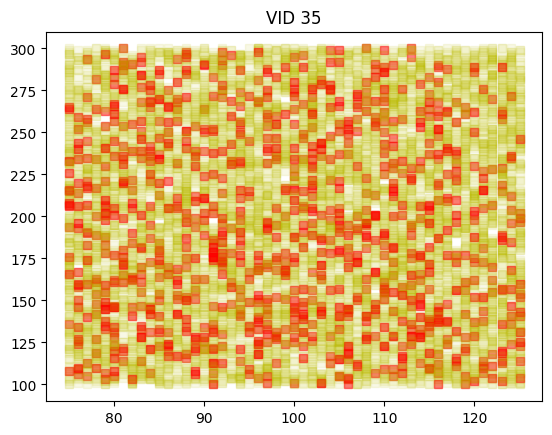

In [3]:
fig, ax = plt.subplots()
ax.set_title('VID 35')

simplify_color = { # Go from 6 different markers/colors to 3 for better visibility once we have a lot of data
	GlitchResult.RESET					: 'sy', # Yellow
	GlitchResult.NORMAL					: 'sg', # Green
	GlitchResult.WEIRD					: 'sy', # Yellow
	GlitchResult.SUCCESS				: 'sr', # Red
	GlitchResult.HALF_SUCCESS			: 'sy', # Yellow
	GlitchResult.BROKEN					: 'sy', # Yellow
}

c.execute('SELECT * FROM mul_f7d1fa4')
rows = c.fetchall()

print(f'Total number of points {len(rows)}, number of non-normal points {len([row for row in rows if row[4] != "NORMAL"])}')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	glitch_values: GlitchSettings = {'ext_offset': ext_offset, 'width': width, 'voltage': voltage, 'prep_voltage': prep_voltage}
	result = GlitchResult[result_name]

	if result == GlitchResult.NORMAL:
		continue
	if glitch_values['voltage'] != 35:
		raise Exception('Wrong voltage')
	ax.plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)